## Importing libraries

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from ggplot import *

## Loading data

In [42]:
datasets = ["Total-Augalinės kilmės produktai","Total-Kietasis mineralinis kuras","Total-Maisto pramonės produktai","Total-Mediena, kamštiena","Total-Nafta ir naftos produktai"]

In [43]:
for i, j in enumerate(datasets):
        exec("timeseries_{} = pd.read_excel(r'.\{}.xlsx', parse_dates=['Date'], index_col='Date')".format(i,j))
        exec("timeseries_{} = timeseries_{}.drop(columns=['Unnamed: 0'])".format(i,i))

## Visualising data

In [4]:
def plot_data(data):
    for i, j in enumerate(data):
        exec("timeseries_{}.Total.plot(figsize=(15, 6))".format(i))
        plt.title(j)
        plt.show()

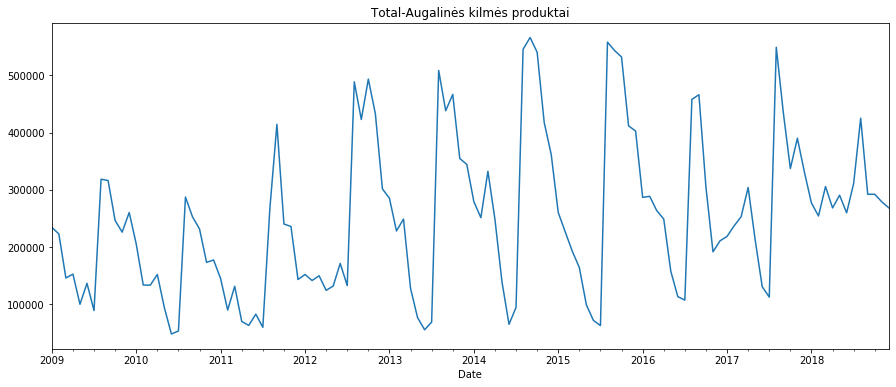

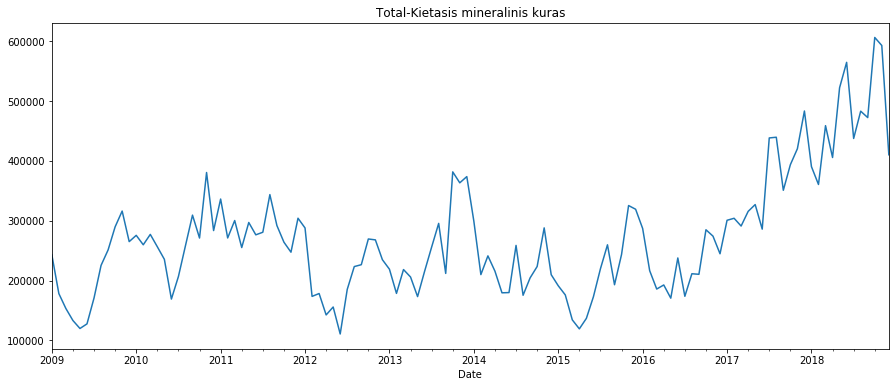

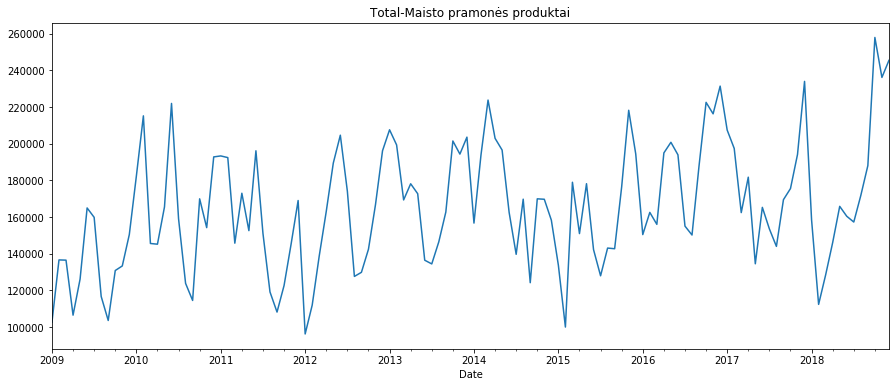

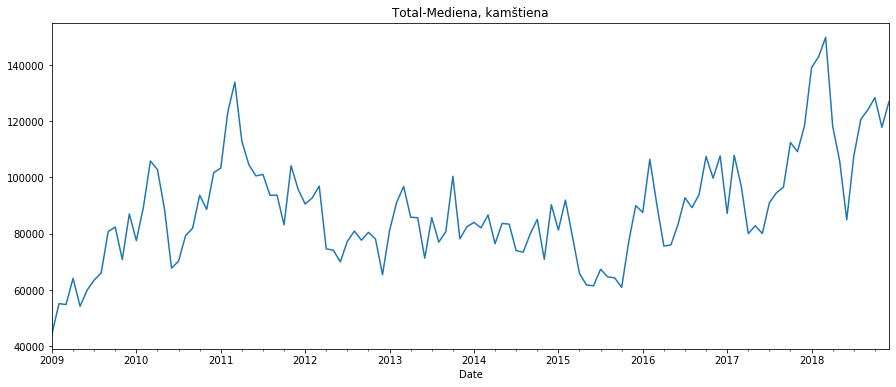

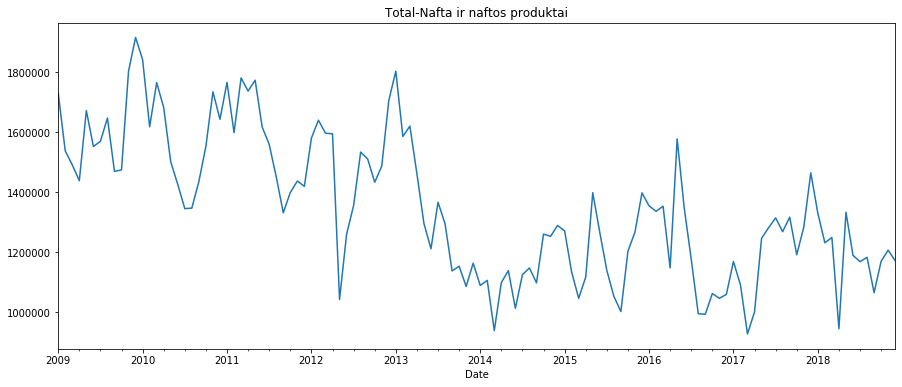

In [5]:
plot_data(datasets)

In [6]:
def plot_boxplots2(data):
    for i, j in enumerate(data):
        exec("timeseries_{}['year'] = [d.year for d in timeseries_{}.index]".format(i,i))
        exec("timeseries_{}['month'] = [d.strftime('%b') for d in timeseries_{}.index]".format(i,i))
        exec("years_{} = timeseries_{}['year'].unique()".format(i,i))

        fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
        exec("fig.suptitle('{}', fontsize=16)".format(j))
        exec("sns.boxplot(x='year', y='Total', data=timeseries_{}, ax=axes[0])".format(i))
        exec("sns.boxplot(x='month', y='Total', data=timeseries_{}.loc[~timeseries_{}.year.isin([2009, 2018]), :])".format(i,i))

        # Set Title
        axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
        axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
        plt.show()

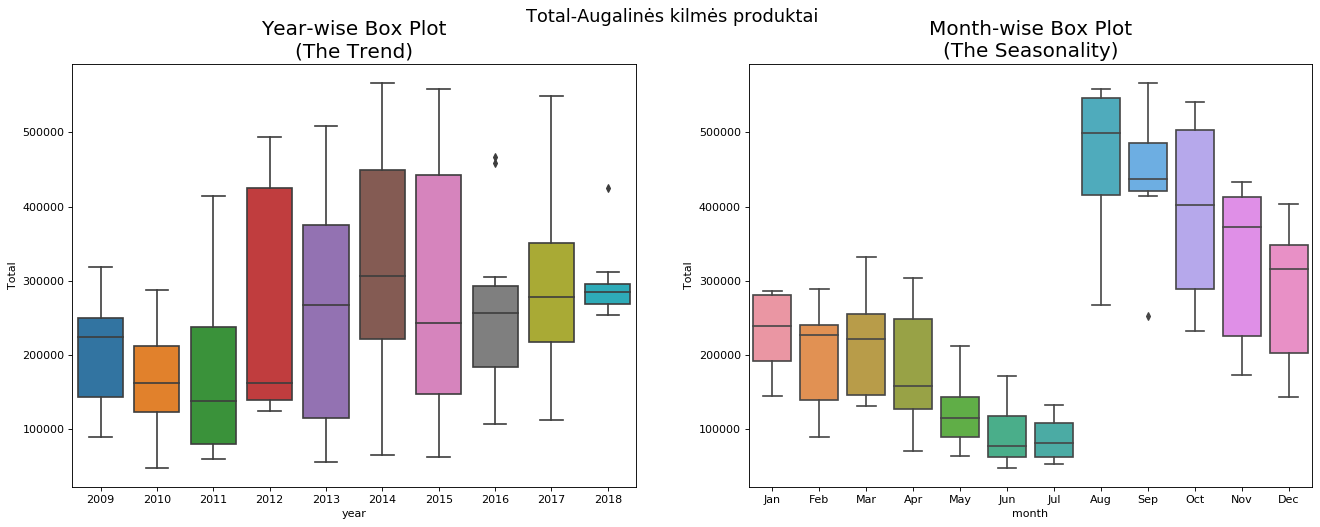

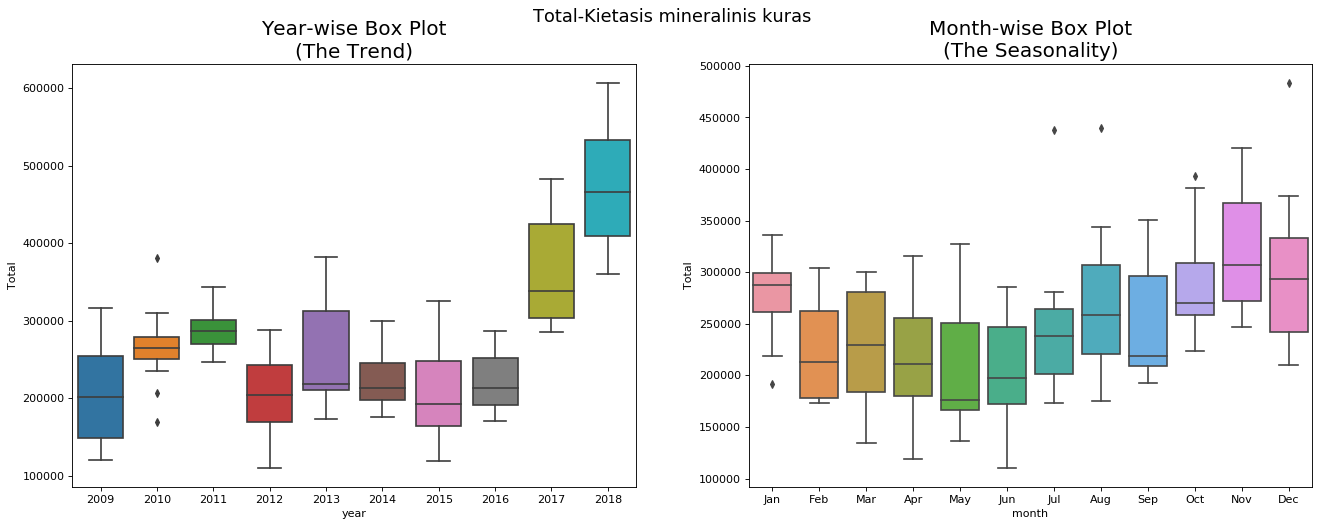

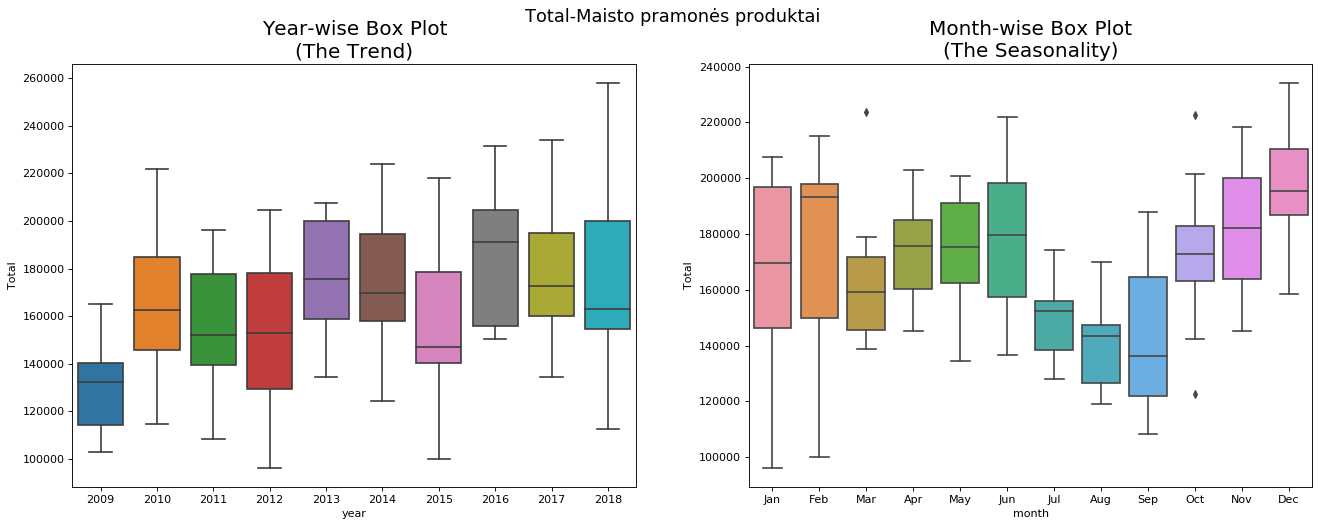

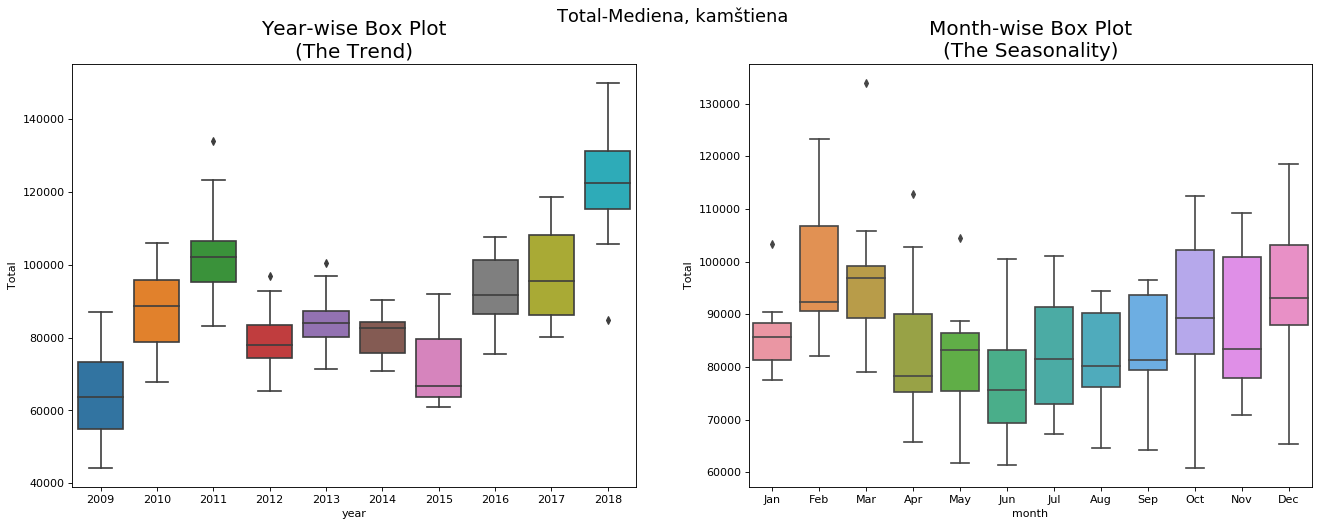

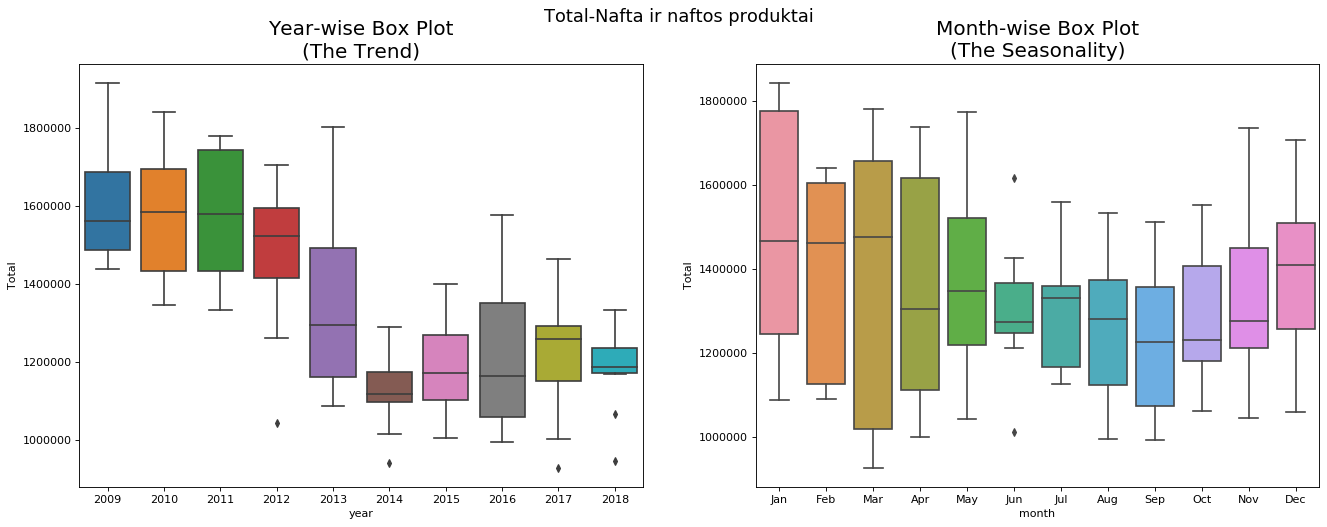

In [7]:
plot_boxplots2(datasets)

## Decomposing time series into trend, seasonality and residuals

In [8]:
def plot_decomposition(data, ixs):
    exec("global result_mul; result_mul = sm.tsa.seasonal_decompose(timeseries_{}['Total'], model='multiplicative',freq=12, extrapolate_trend = 12)".format(ixs,ixs))
    global result_mul
    trend = result_mul.trend
    seasonal = result_mul.seasonal
    residuals = result_mul.resid
    plt.figure(figsize=(15,15))
    plt.subplot(411)
    plt.title(data)
    exec("plt.plot(timeseries_{}['Total'], label= 'Original Data')".format(ixs))
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend,label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonal')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residuals,label='Residuals')
    plt.legend(loc='best')

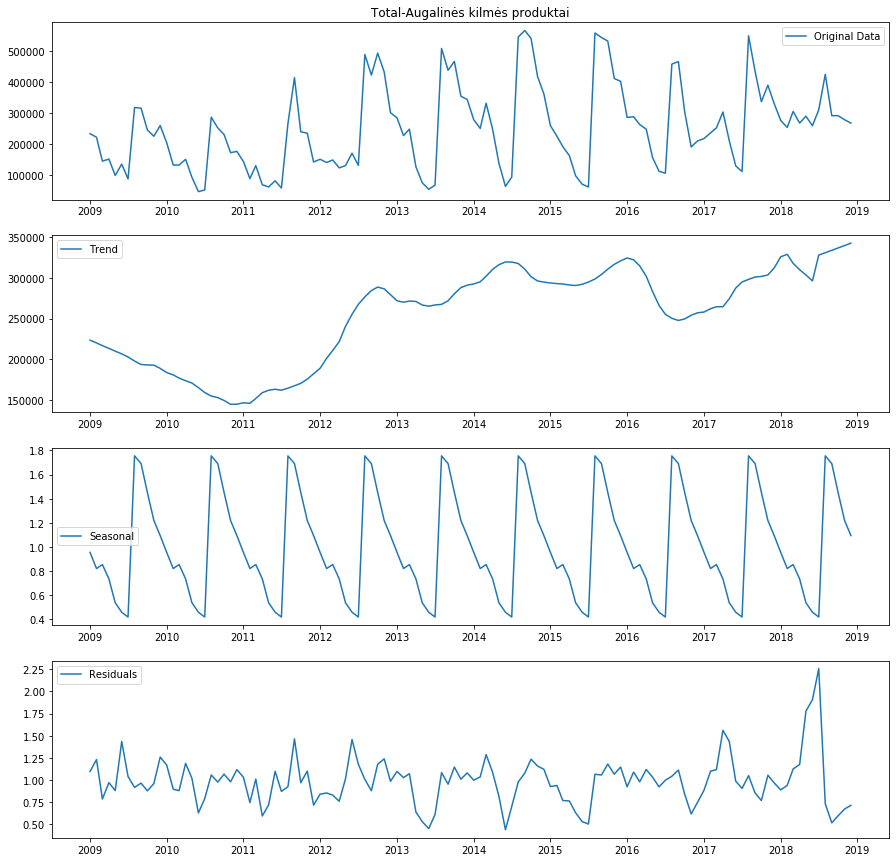

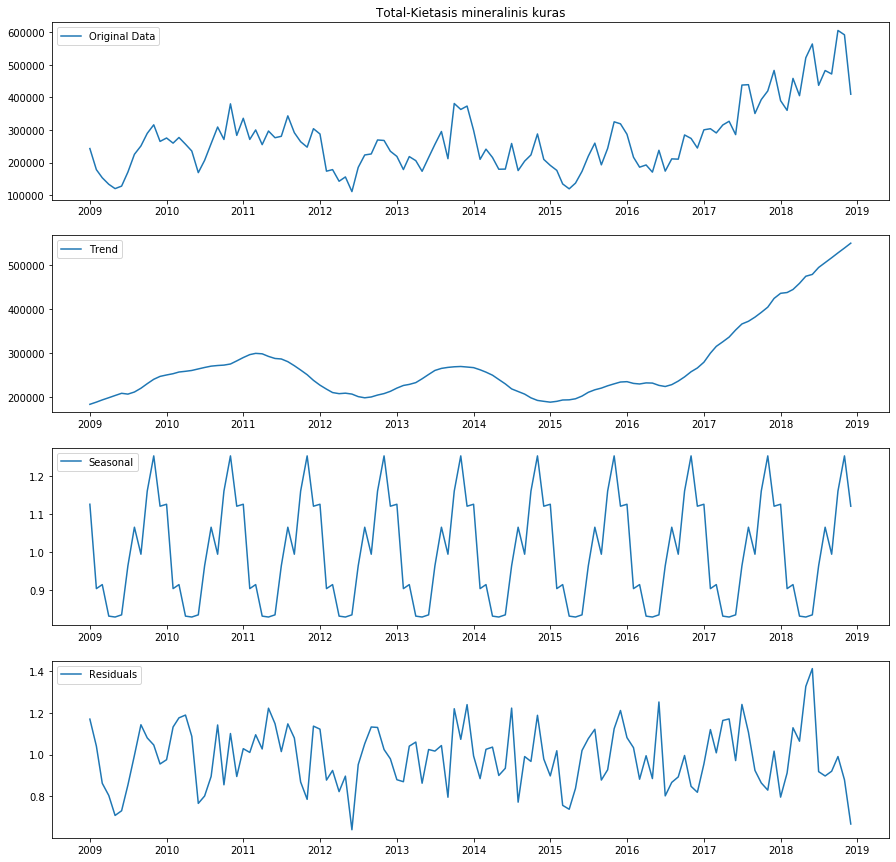

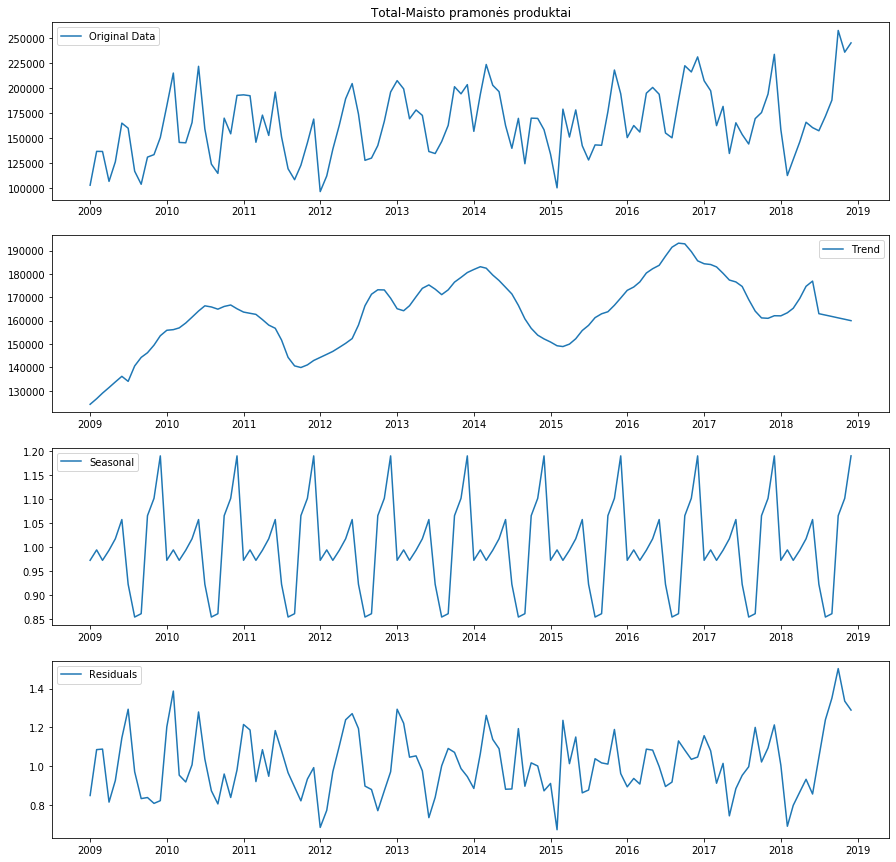

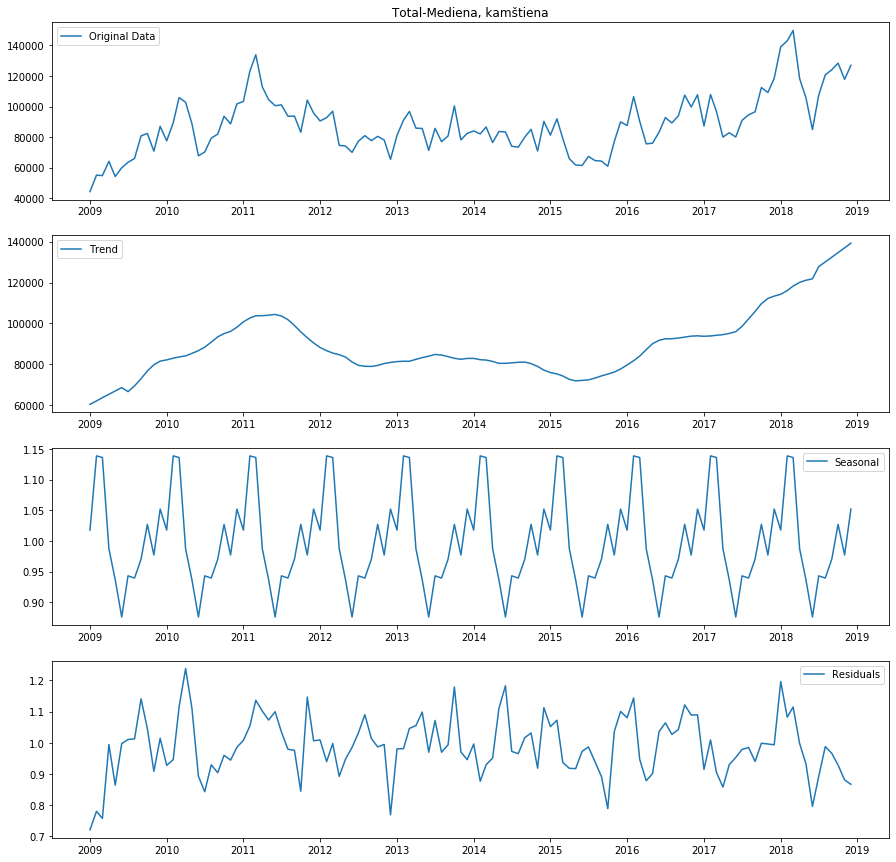

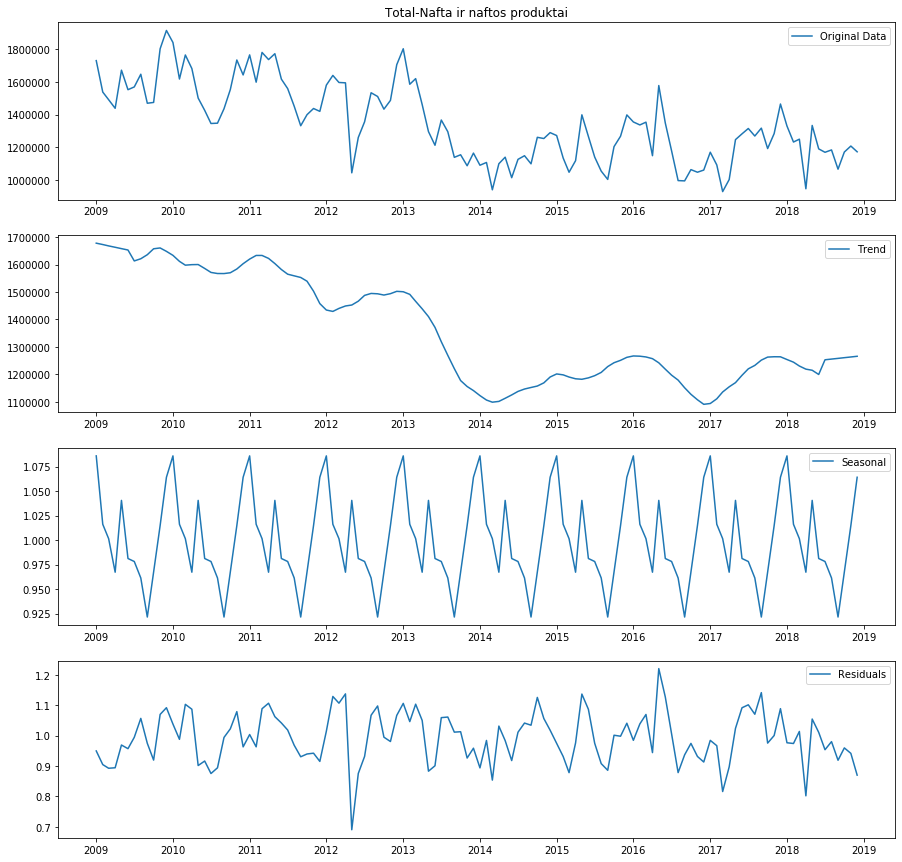

In [9]:
for i, j in enumerate(datasets):
    plot_decomposition(j, i)

## Inspecting data
### Testing the seasonality with autocorrelation and partial autocorrelation

In [10]:
for i, j in enumerate(datasets):
    exec("y_{} = timeseries_{}.Total.resample('MS').mean()".format(i,i))

C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


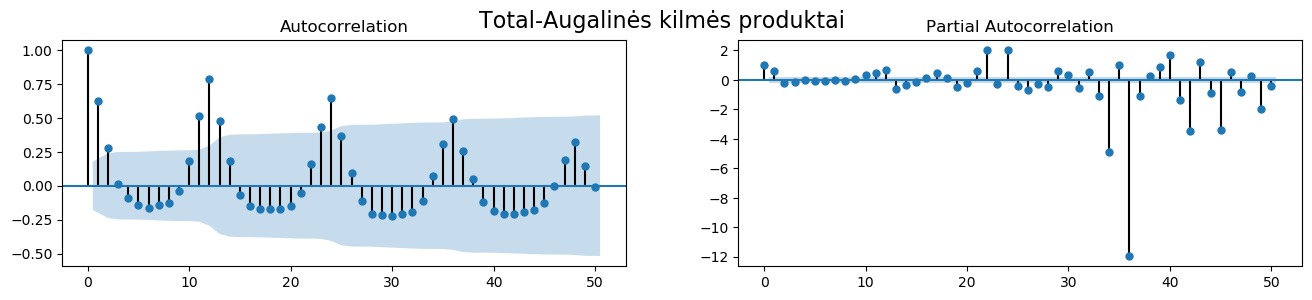

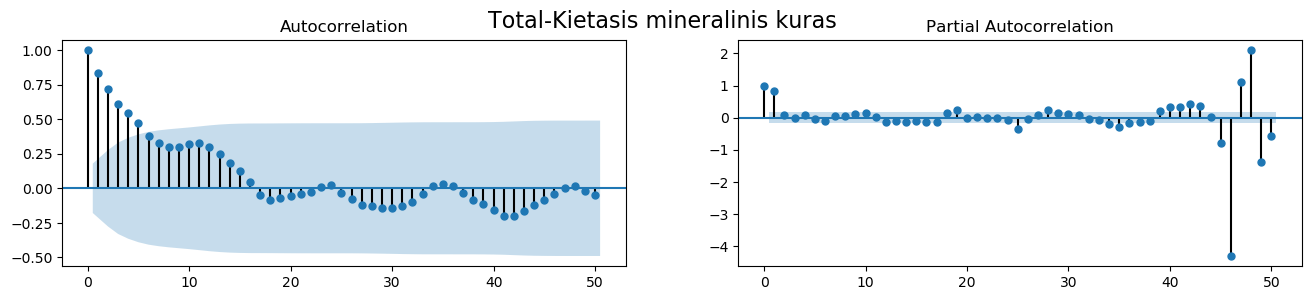

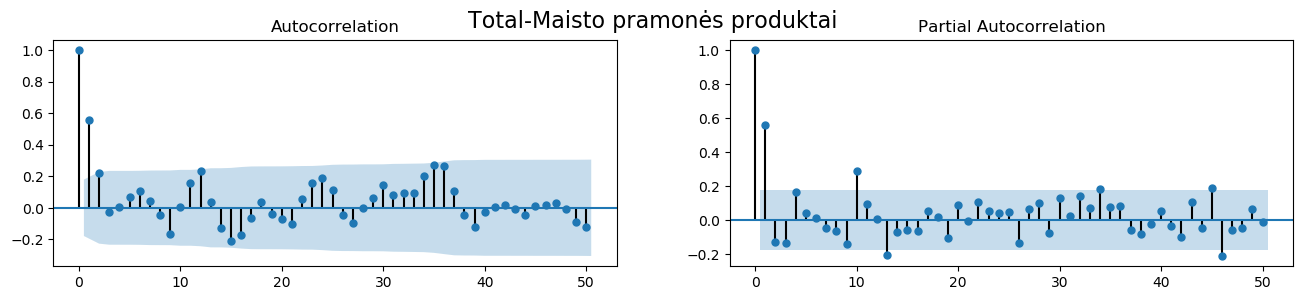

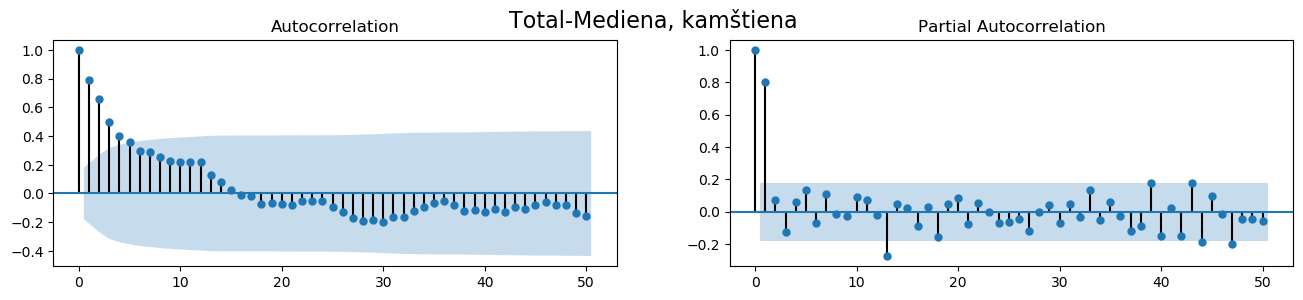

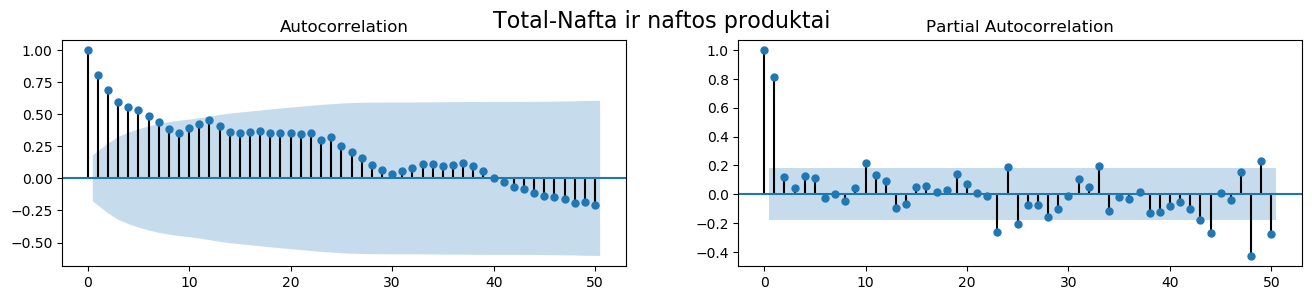

In [11]:
for m,n in enumerate(datasets):
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    exec("fig.suptitle('{}', fontsize=16)".format(n))
    exec("plot_acf(y_{}.tolist(), lags=50, ax=axes[0])".format(m))
    exec("plot_pacf(y_{}.tolist(), lags=50, ax=axes[1])".format(m))

Most of the residuals are below the significance level, therefore they are independent. Some residuals are above the alpha level, therefore they are somewhat autocorrelated at specific lag. In the first autocorrelation plot some seasonalities can be seen.

#### Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value. 

#### If the p-values for the Ljung-Box chi-square statistics are all greater than 0.05, then none of the correlations for the autocorrelation function of the residuals are significant. We can conclude that the model meets the assumption that the residuals are independent.

#### Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

#### Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

## Applying ARIMA model

In [12]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Possible parameter combinations for Seasonal ARIMA:')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Possible parameter combinations for Seasonal ARIMA:
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [13]:
def get_arima_params(data,name):
    for param in pdq:
        params = []
        params_seasonal = []
        results_aic = []
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data, order=param, 
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                params.append(param)
                params_seasonal.append(param_seasonal)
                results_aic.append(results.aic)
#                     print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

            except:
                continue

    min_aic = min(results_aic) 
    idx = results_aic.index(min_aic)
    selected_params = params[idx]
    selected_seas_params = params_seasonal[idx]

    print("----------")
    print("Selected parameters for {}:".format(name))
    print('ARIMA{}x{} - AIC:{}'.format(selected_params, selected_seas_params, min_aic))
    return selected_params, selected_seas_params, min_aic

# ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2344.917844508114 - timeseries_0
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:2309.9228730237464 - timeseries_1
# ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2186.2581641956604 - timeseries_2
# ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1995.964179010848 - timeseries_3
# ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2487.2994410900656 - timeseries_4 


In [14]:
for i in range(0,len(datasets)):
    exec("selected_params_{}, selected_seas_params_{}, min_aic_{} = get_arima_params(y_{},datasets[{}])".format(i,i,i,i,i))

----------
Selected parameters for Total-Augalinės kilmės produktai:
ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:2344.917844508114
----------
Selected parameters for Total-Kietasis mineralinis kuras:
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:2309.9228730237464
----------
Selected parameters for Total-Maisto pramonės produktai:
ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:2186.2581641956604
----------
Selected parameters for Total-Mediena, kamštiena:
ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:1995.964179010848


C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


----------
Selected parameters for Total-Nafta ir naftos produktai:
ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:2487.2994410900656


In [15]:
# The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 
# The P>|z| column shows the significance of each feature weight. 
# If weight has a p-value lower or close to 0.05, it is reasonable to retain it in the model.

In [16]:
def apply_arima(data,ix):
    exec("global mod; mod = sm.tsa.statespace.SARIMAX(y_{}[:2017],order=selected_params_{},seasonal_order=selected_seas_params_{},enforce_stationarity=False,enforce_invertibility=False)".format(ix,ix,ix))
    global mod
    results = mod.fit()
    print(data)
    print(results.summary().tables[1])
    return results

In [17]:
for i in range(0, len(datasets)):
    exec("results_{} = apply_arima(datasets[{}],{})".format(i,i,i))

Total-Augalinės kilmės produktai
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5600      0.092      6.111      0.000       0.380       0.740
ma.L1         -0.9137      0.040    -22.904      0.000      -0.992      -0.836
ma.S.L12      -0.3849      0.124     -3.115      0.002      -0.627      -0.143
sigma2      5.394e+09   5.05e-12   1.07e+21      0.000    5.39e+09    5.39e+09
Total-Kietasis mineralinis kuras
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0365      0.431      0.085      0.933      -0.808       0.881
ma.L1         -0.4663      0.354     -1.317      0.188      -1.160       0.228
ar.S.L12      -0.5350      0.224     -2.385      0.017      -0.975      -0.095
ma.S.L12      -0.4241      0.204     -2.083      0.037      -0.82

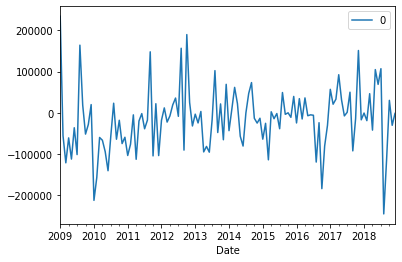

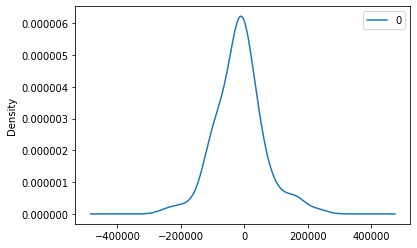

                   0
count     120.000000
mean   -15755.556939
std     75785.772046
min   -244912.117953
25%    -59848.993743
50%    -14438.333550
75%     21863.687565
max    234280.000000


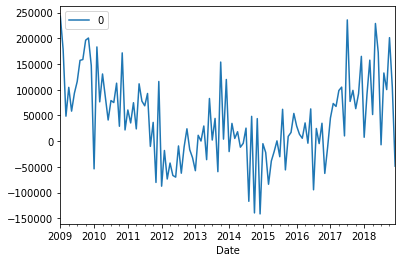

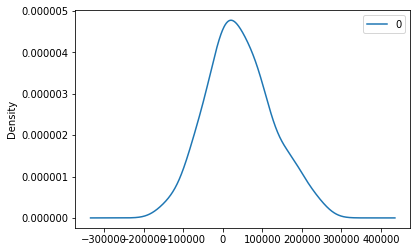

                   0
count     120.000000
mean    42241.141498
std     81297.141504
min   -141626.975860
25%    -10473.326525
50%     35099.860868
75%     92864.262288
max    243020.000000


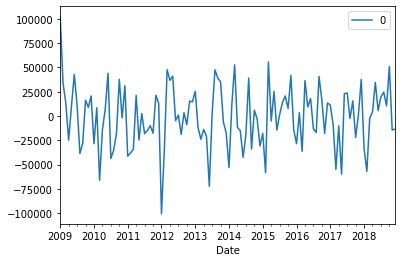

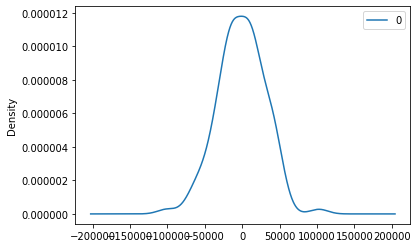

                   0
count     120.000000
mean    -1005.970462
std     31359.897738
min   -100869.925948
25%    -18419.835866
50%      1139.936688
75%     19951.978426
max    102666.000000


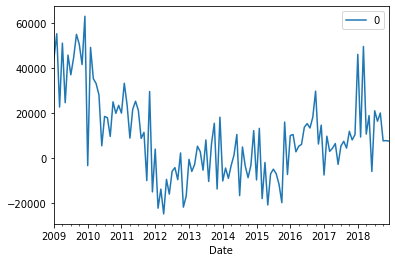

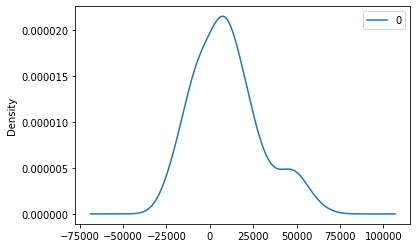

                  0
count    120.000000
mean    9618.702091
std    19042.168597
min   -24834.723530
25%    -4593.016678
50%     7645.336293
75%    19836.844009
max    62905.582624


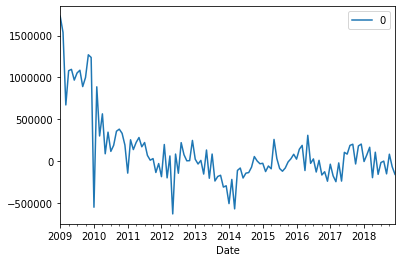

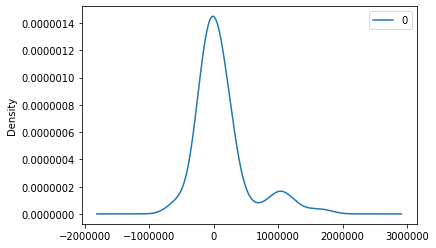

                  0
count  1.200000e+02
mean   1.172155e+05
std    4.082601e+05
min   -6.284723e+05
25%   -1.256523e+05
50%    1.837344e+04
75%    1.950904e+05
max    1.730868e+06


In [40]:
for i, j in enumerate(datasets):
    exec("residuals_{} = pd.DataFrame(results_{}.resid)".format(i,i))
    exec("residuals_{}.plot()".format(i))
    plt.show()
    exec("residuals_{}.plot(kind='kde')".format(i))
    plt.show()
    exec("print(residuals_{}.describe())".format(i))

Total-Augalinės kilmės produktai


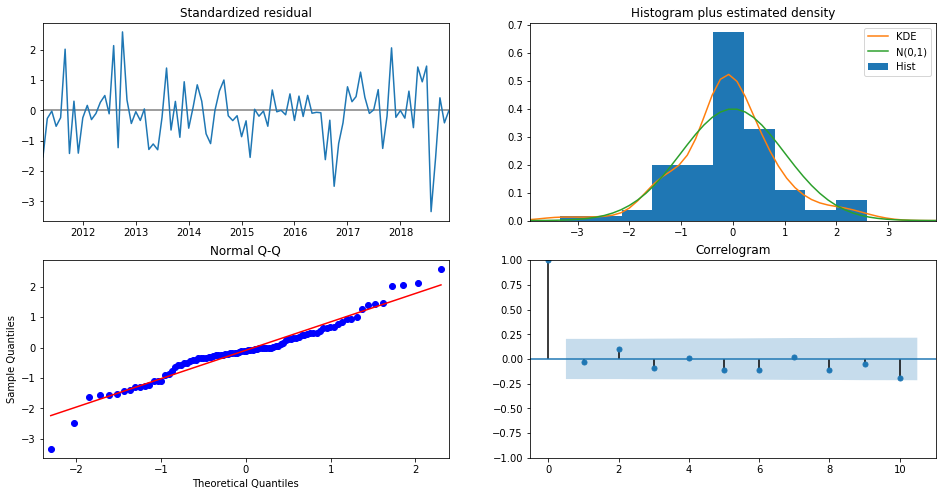

Total-Kietasis mineralinis kuras


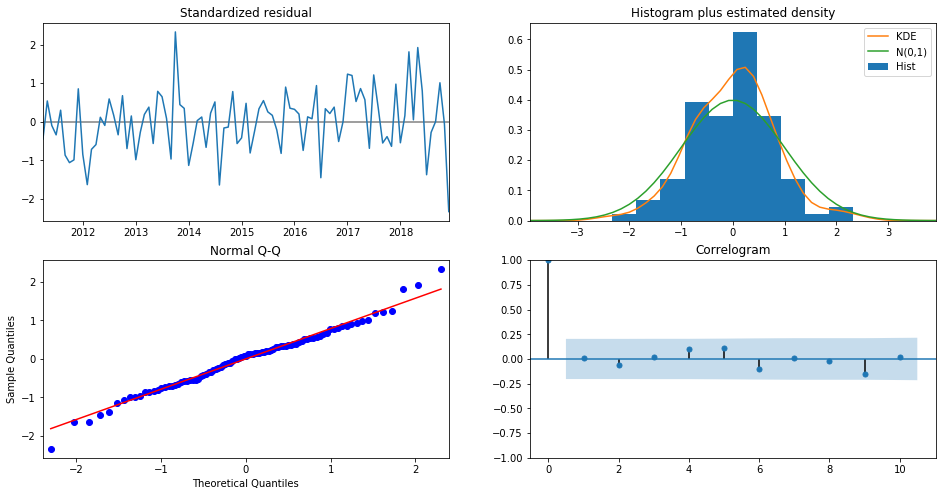

Total-Maisto pramonės produktai


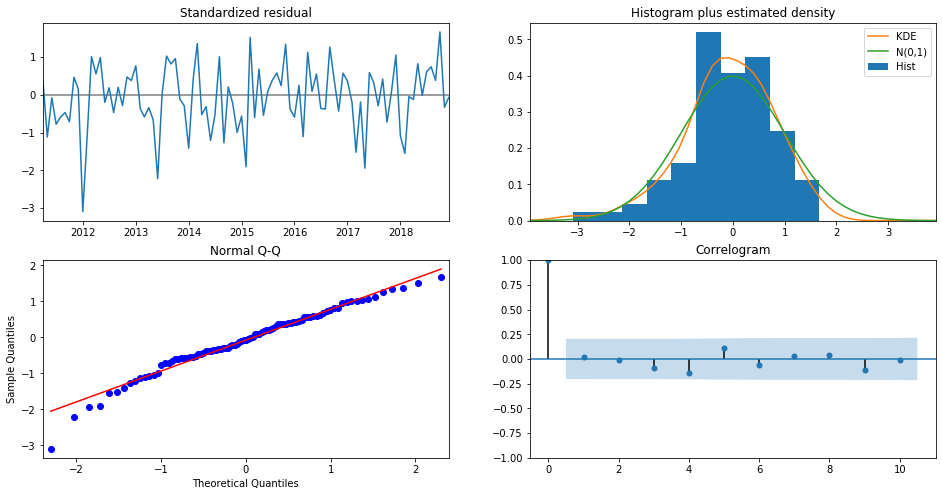

Total-Mediena, kamštiena


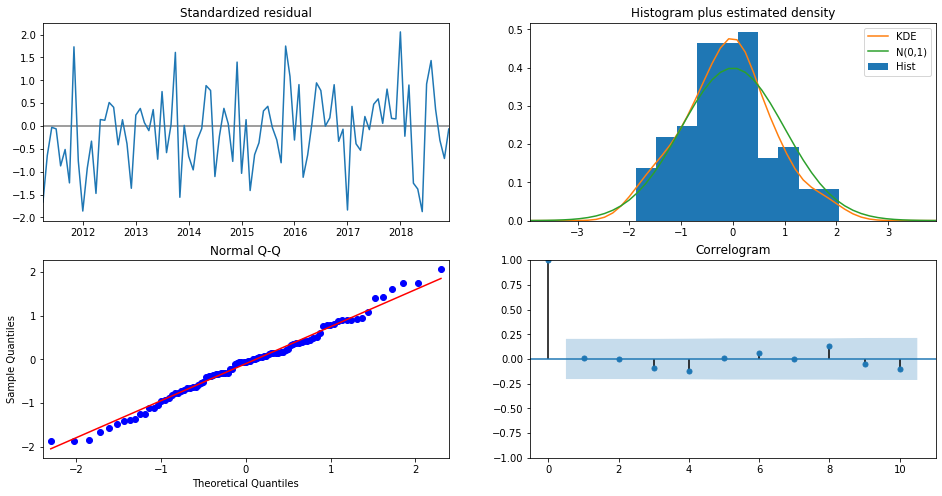

Total-Nafta ir naftos produktai


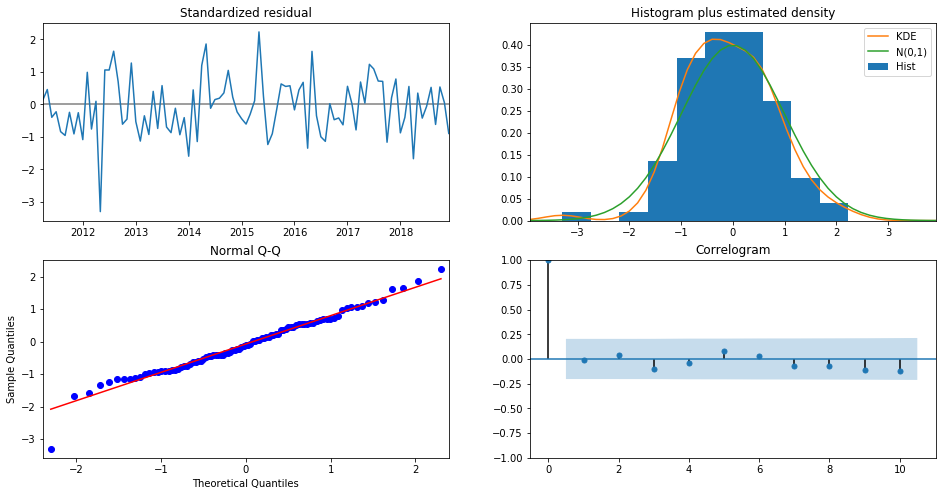

In [18]:
for i,j in enumerate(datasets):
    exec("results_{}.plot_diagnostics(figsize=(16, 8))".format(i))
    print(j)
    plt.show()

## Creating models with significant weights only

In [19]:
mod_0 = sm.tsa.statespace.SARIMAX(y_0[:2017],order=(1,1,1),seasonal_order=(0, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
results_0 = mod_0.fit()
print(datasets[0])
print(results_0.summary().tables[1])

Total-Augalinės kilmės produktai
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5600      0.092      6.111      0.000       0.380       0.740
ma.L1         -0.9137      0.040    -22.904      0.000      -0.992      -0.836
ma.S.L12      -0.3849      0.124     -3.115      0.002      -0.627      -0.143
sigma2      5.394e+09   5.05e-12   1.07e+21      0.000    5.39e+09    5.39e+09


In [20]:
mod_1 = sm.tsa.statespace.SARIMAX(y_1[:2017],order=(0,0,1),seasonal_order=(0, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
results_1 = mod_1.fit()
print(datasets[1])
print(results_1.summary().tables[1])

Total-Kietasis mineralinis kuras
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5876      0.114      5.149      0.000       0.364       0.811
ma.S.L12      -0.3933      0.134     -2.933      0.003      -0.656      -0.130
sigma2      8.425e+09   1.04e-12   8.07e+21      0.000    8.43e+09    8.43e+09


In [21]:
mod_2 = sm.tsa.statespace.SARIMAX(y_2[:2017],order=(0,1,1),seasonal_order=(0, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
results_2 = mod_2.fit()
print(datasets[2])
print(results_2.summary().tables[1])

Total-Maisto pramonės produktai
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3906      0.122     -3.191      0.001      -0.630      -0.151
ma.S.L12      -0.6089      0.100     -6.067      0.000      -0.806      -0.412
sigma2      1.145e+09    1.7e-11   6.74e+19      0.000    1.14e+09    1.14e+09


In [22]:
mod_3 = sm.tsa.statespace.SARIMAX(y_3[:2017],order=(0,0,1),seasonal_order=(0, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
results_3 = mod_3.fit()
print(datasets[3])
print(results_3.summary().tables[1])

Total-Mediena, kamštiena
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5876      0.132      4.453      0.000       0.329       0.846
ma.S.L12      -0.2344      0.118     -1.979      0.048      -0.467      -0.002
sigma2      3.122e+08   3.92e-11   7.96e+18      0.000    3.12e+08    3.12e+08


In [23]:
mod_4 = sm.tsa.statespace.SARIMAX(y_4[:2017],order=(0,0,1),seasonal_order=(0, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
results_4 = mod_4.fit()
print(datasets[4])
print(results_4.summary().tables[1])

Total-Nafta ir naftos produktai
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5324      0.135      3.952      0.000       0.268       0.796
ma.S.L12      -0.3358      0.089     -3.773      0.000      -0.510      -0.161
sigma2      4.479e+10   3.13e-13   1.43e+23      0.000    4.48e+10    4.48e+10


## Checking the model precision on 2018 data

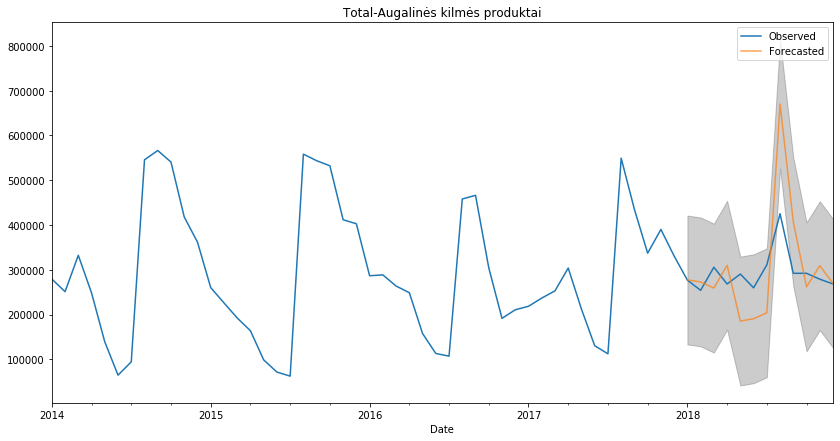

The Mean Squared Error of our forecasts for Total-Augalinės kilmės produktai is  8879260610.05
The Root Mean Squared Error of our forecasts for Total-Augalinės kilmės produktai is  94229.83


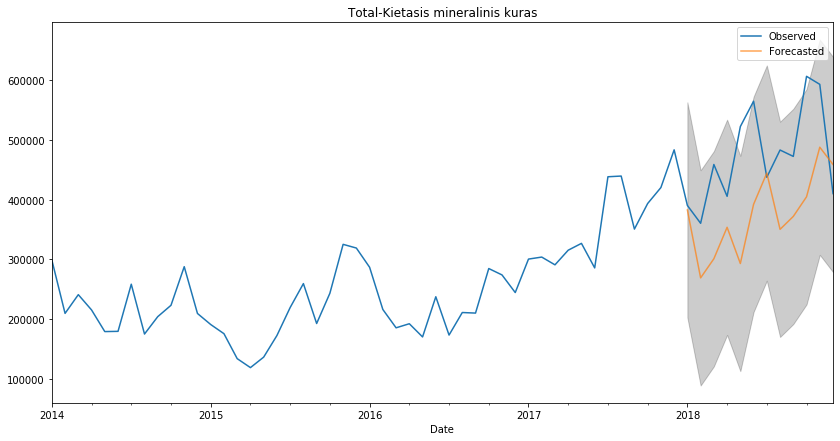

The Mean Squared Error of our forecasts for Total-Kietasis mineralinis kuras is  16639962061.57
The Root Mean Squared Error of our forecasts for Total-Kietasis mineralinis kuras is  128995.98


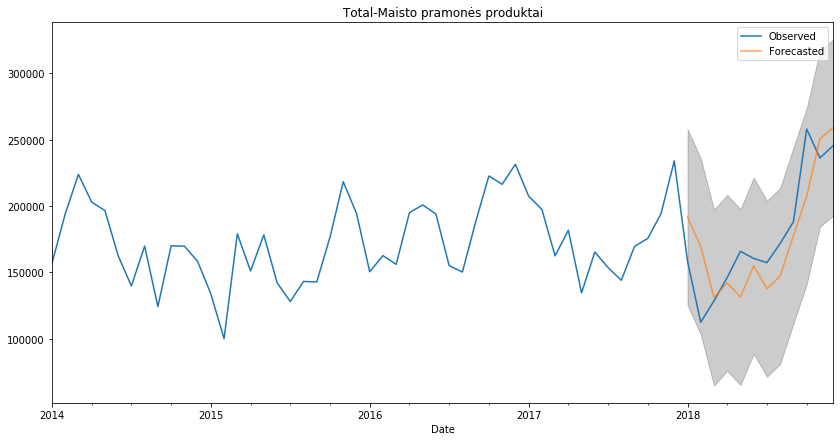

The Mean Squared Error of our forecasts for Total-Maisto pramonės produktai is  806609207.35
The Root Mean Squared Error of our forecasts for Total-Maisto pramonės produktai is  28400.87


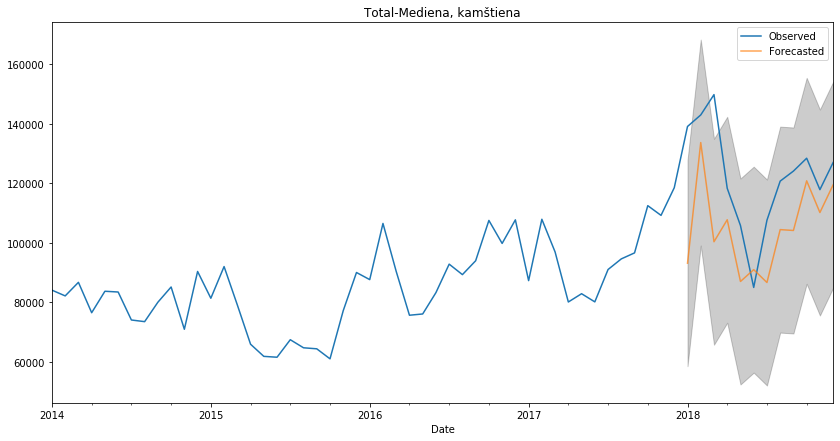

The Mean Squared Error of our forecasts for Total-Mediena, kamštiena is  535424646.36
The Root Mean Squared Error of our forecasts for Total-Mediena, kamštiena is  23139.24


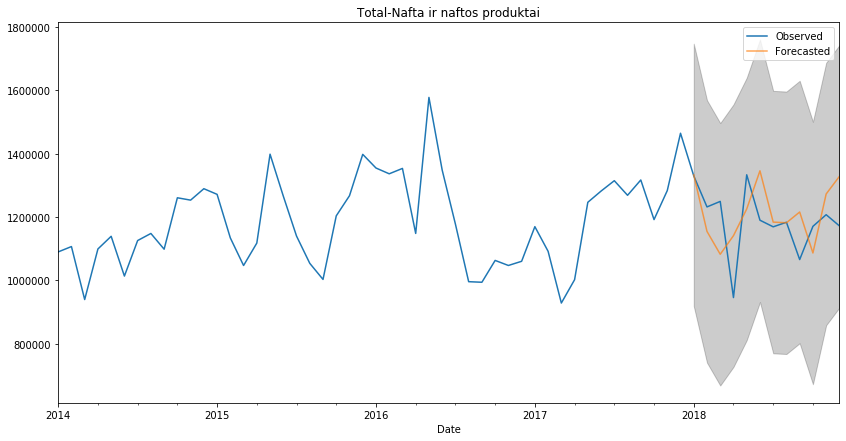

The Mean Squared Error of our forecasts for Total-Nafta ir naftos produktai is  13915311297.44
The Root Mean Squared Error of our forecasts for Total-Nafta ir naftos produktai is  117963.18


In [24]:
for i,j in enumerate(datasets):
    exec("pred_{} = results_{}.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)".format(i,i))
    exec("pred_ci_{} = pred_{}.conf_int()".format(i,i))
    exec("ax = y_{}['2014':].plot(label='Observed')".format(i))
    exec("pred_{}.predicted_mean.plot(ax=ax, label='Forecasted', alpha=.7, figsize=(14, 7))".format(i,i))
    exec("ax.fill_between(pred_ci_{}.index, pred_ci_{}.iloc[:, 0], pred_ci_{}.iloc[:, 1], color='k', alpha=.2)".format(i,i,i))
    ax.set_xlabel('Date')
    plt.legend()
    plt.title(j)
    plt.show()

    exec("y_forecasted_{} = pred_{}.predicted_mean".format(i,i))
    exec("y_truth_{} = y_{}['2018-01-01':]".format(i,i))
    exec("mse_{} = ((y_forecasted_{} - y_truth_{}) ** 2).mean()".format(i,i,i))
    exec("print('The Mean Squared Error of our forecasts for {} is ',(round(mse_{}, 2)))".format(j,i))
    exec("print('The Root Mean Squared Error of our forecasts for {} is ',(round(np.sqrt(mse_{}), 2)))".format(j,i))

## Forecasting data for year 2019

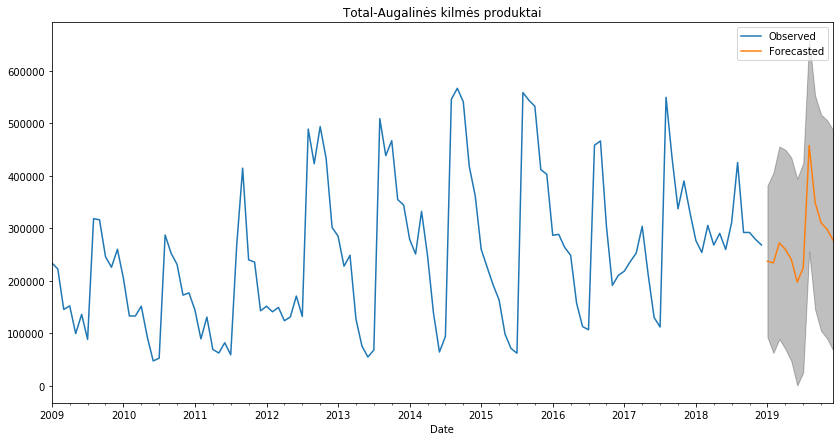

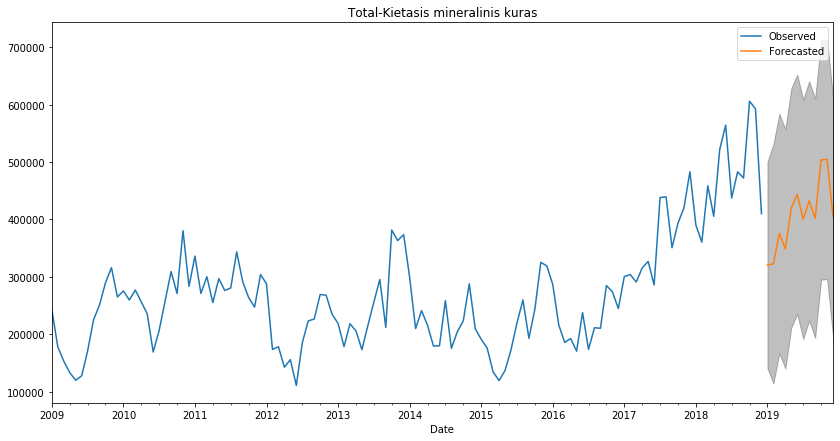

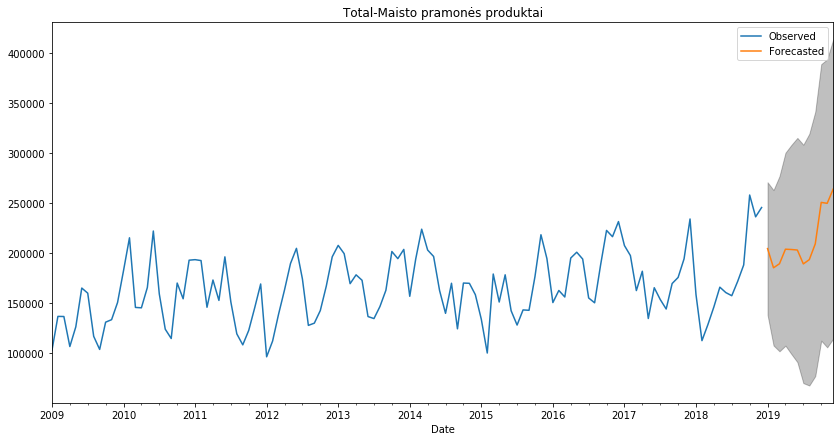

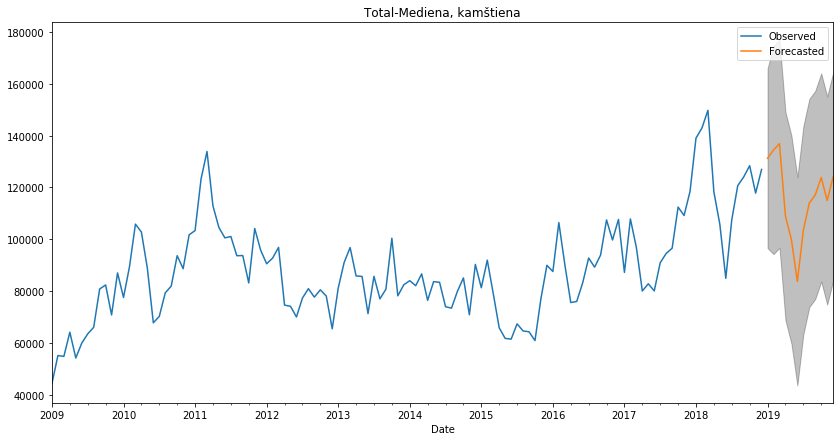

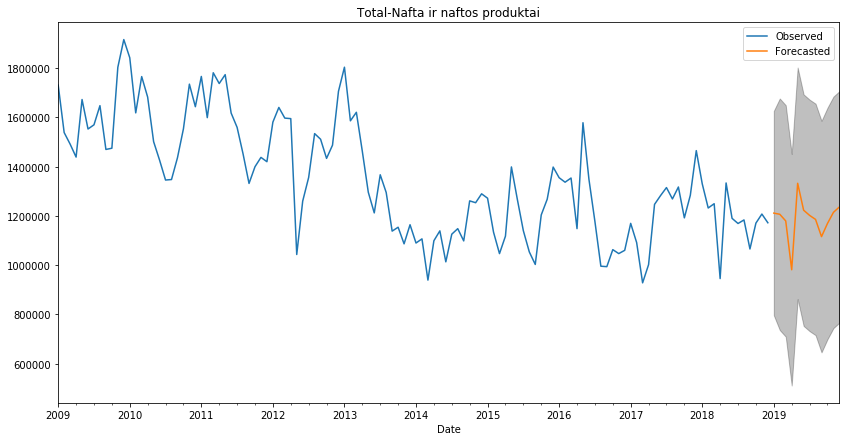

In [25]:
for i,j in enumerate(datasets):
    exec("pred_uc_{} = results_{}.get_forecast(steps=12)".format(i,i))
    exec("pred_ci2_{} = pred_uc_{}.conf_int()".format(i,i))
    exec("ax = y_{}.plot(label='Observed', figsize=(14, 7))".format(i))
    exec("pred_uc_{}.predicted_mean.plot(ax=ax, label='Forecasted')".format(i))
    exec("ax.fill_between(pred_ci2_{}.index,pred_ci2_{}.iloc[:, 0],pred_ci2_{}.iloc[:, 1], color='k', alpha=.25)".format(i,i,i))
    ax.set_xlabel('Date')
    plt.legend()
    plt.title(j)
    plt.show()

--------------------------

## Aggregating time series data

In [26]:
for i, j in enumerate(datasets):
    exec("timeser_{} = pd.read_excel(r'.\data\{}.xlsx', parse_dates=['Date'])".format(i,j))
    exec("timeser_{} = timeser_{}.drop(columns=['Unnamed: 0'])".format(i,i))
    exec("timeser_{}['Total_{}'] = timeser_{}['Total']".format(i,i,i))
    exec("timeser_{} = timeser_{}.drop(columns=['Total'])".format(i,i))

In [27]:
dfs = [timeser_0,timeser_1,timeser_2,timeser_3,timeser_4]
dfs = [df.set_index('Date') for df in dfs]
aggregated = dfs[0].join(dfs[1:])

In [28]:
aggregated.groupby(aggregated.index.year).sum().head(10)

,Total_0,Total_1,Total_2,Total_3,Total_4
Date,,,,,
2009,2447423,2472768,1568508,783132,19304408
2010,1940198,3182212,1990525,1047699,18895653
2011,1940663,3467398,1868873,1249956,18873117
2012,3142249,2455442,1841475,958908,17742729
2013,3202705,3091782,2107049,1016342,16184184
2014,3841904,2684638,2068383,969900,13563342
2015,3524396,2490396,1887408,865708,14300871
2016,3096921,2688903,2222514,1109917,14457255
2017,3509489,4349299,2119892,1157019,14561318


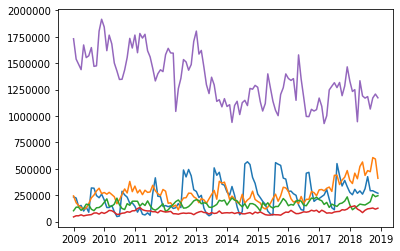

In [29]:
plt.plot(aggregated)

In [30]:
sum_of_all = aggregated.sum(axis = 1)

Text(0, 0.5, 'Aggregated data')

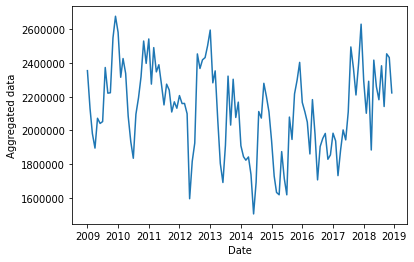

In [31]:
plt.plot(sum_of_all)
plt.xlabel('Date')
plt.ylabel('Aggregated data')

In [32]:
selected_params, selected_seas_params, min_aic = get_arima_params(sum_of_all,"Aggregated data")

C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, Valu

C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, Valu

----------
Selected parameters for Aggregated data:
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:2533.3756135179897


In [33]:
mod = sm.tsa.statespace.SARIMAX(sum_of_all[:2017],order=selected_params,seasonal_order=selected_seas_params,enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3175      0.447      0.710      0.478      -0.559       1.194
ma.L1         -0.5754      0.405     -1.422      0.155      -1.369       0.218
ar.S.L12      -0.4067      0.232     -1.752      0.080      -0.862       0.048
ma.S.L12      -0.2363      0.174     -1.355      0.175      -0.578       0.106
sigma2      4.656e+10   1.02e-11   4.56e+21      0.000    4.66e+10    4.66e+10


In [34]:
mod_sig = sm.tsa.statespace.SARIMAX(sum_of_all[:2017],order=(0,0,1),seasonal_order=(0, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
results_sig = mod_sig.fit()
print(results_sig.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5395      0.133      4.046      0.000       0.278       0.801
ma.S.L12      -0.2981      0.092     -3.249      0.001      -0.478      -0.118
sigma2      6.603e+10    3.6e-13   1.83e+23      0.000     6.6e+10     6.6e+10


C:\Users\RAMUNE-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


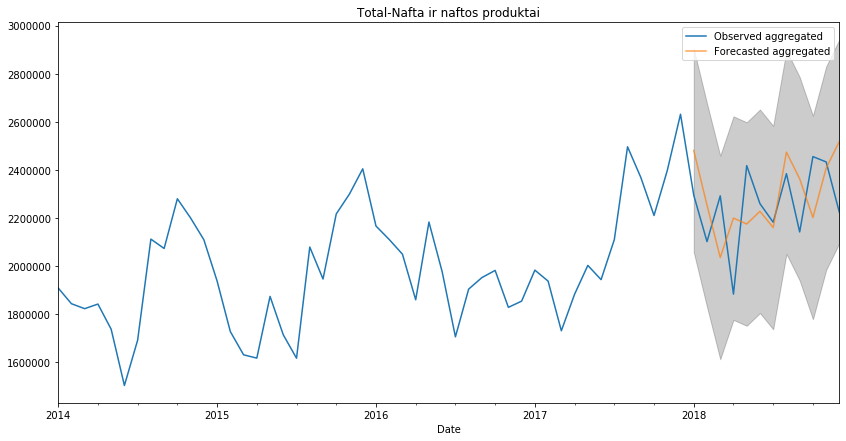

The Mean Squared Error of our forecasts for aggregated data is  41035572756.63
The Root Mean Squared Error of our forecasts for aggregated data is  202572.39


In [35]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = sum_of_all['2014':].plot(label='Observed aggregated')
pred.predicted_mean.plot(ax=ax, label='Forecasted aggregated', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
plt.legend()
plt.title(j)
plt.show()

y_forecasted = pred.predicted_mean
y_truth = sum_of_all['2018-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts for aggregated data is ',(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts for aggregated data is ',(round(np.sqrt(mse), 2)))

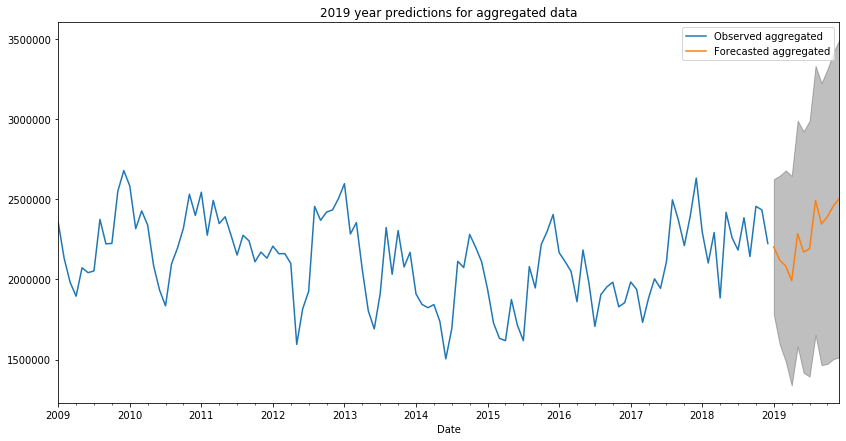

In [36]:
pred_uc = results.get_forecast(steps=12)
pred_ci2 = pred_uc.conf_int()
ax = sum_of_all.plot(label='Observed aggregated', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted aggregated')
ax.fill_between(pred_ci2.index,pred_ci2.iloc[:, 0],pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
plt.legend()
plt.title("2019 year predictions for aggregated data")
plt.show()